### Imports

In [1]:
import numpy as np
import pandas as pd
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.0 Fetch Raw Data

In [2]:
# Pull dataset from Kaggle
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/icarias/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2


In [3]:
filename = os.listdir(path)[0]
print(filename)

adult.csv


In [4]:
df = pd.read_csv(os.path.join(path, filename))

### 2.0 EDA

##### About the data - *Kaggle*:

"An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc."

**Acknowledgements**

This dataset named “adult” is found in the UCI machine learning repository
http://www.cs.toronto.edu/~delve/data/adult/desc.html

The detailed description on the dataset can be found in the original UCI documentation
http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

In [5]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [6]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### 3.0 Data Preprocessing

#### Data Cleansing

In [7]:
# Check if we have null values - if so, remove them
df = df.replace('?', np.nan)
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [8]:
# I will be removing the records with null values
df.shape

(48842, 15)

In [9]:
df = df.dropna()

In [10]:
df.shape # around 93% of raw data - ok

(45222, 15)

In [11]:
# Check if we have empty string values - if so, remove them
(df == '').sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [12]:
# Check if any columns have only one or too many unique values - if so, remove them
df.nunique()

age                   74
workclass              7
fnlwgt             26741
education             16
educational-num       16
marital-status         7
occupation            14
relationship           6
race                   5
gender                 2
capital-gain         121
capital-loss          97
hours-per-week        96
native-country        41
income                 2
dtype: int64

In [13]:
df = df.drop(['fnlwgt', 'capital-gain', 'capital-loss'], axis=1)

In [14]:
df.columns

Index(['age', 'workclass', 'education', 'educational-num', 'marital-status',
       'occupation', 'relationship', 'race', 'gender', 'hours-per-week',
       'native-country', 'income'],
      dtype='object')

<Axes: xlabel='age', ylabel='Count'>

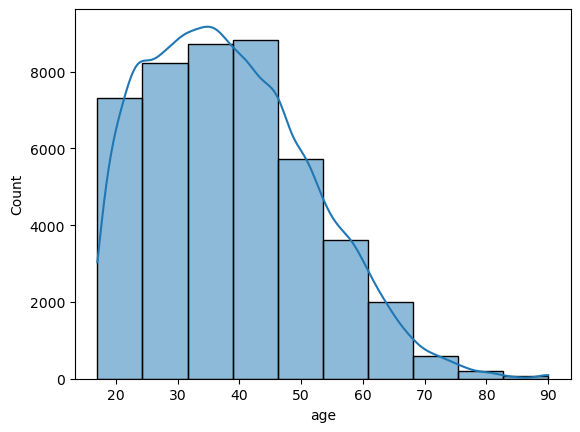

In [15]:
sns.histplot(df['age'], bins=10, kde=True)

In [16]:
# Add ages to categories
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']

# Create binned age column
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

<Axes: xlabel='age_group', ylabel='Count'>

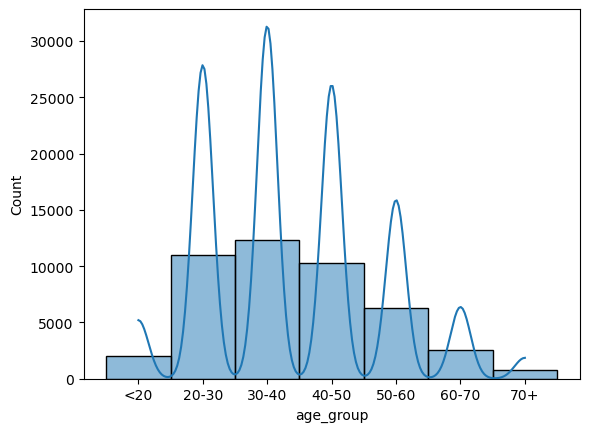

In [17]:
sns.histplot(df['age_group'], bins=10, kde=True)

In [18]:
df = df.drop(['age'], axis=1)

In [19]:
df['workclass'].value_counts()

workclass
Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: count, dtype: int64

In [20]:
df['workclass'] = df['workclass'].replace({
    'Self-emp-not-inc': 'Self-employed',
    'Self-emp-inc': 'Self-employed', 
    'Local-gov': 'Gov-worker', 
    'State-gov': 'Gov-worker', 
    'Federal-gov': 'Gov-worker', 
})
# group these to the same mapping as they're fairly similar 

In [21]:
df = df[df['workclass'] != 'Without-pay'] # very small outlier - can affect generalization of model (overfitting)

In [22]:
df['workclass'].value_counts()

workclass
Private          33307
Gov-worker        6452
Self-employed     5442
Name: count, dtype: int64

In [23]:
df['education'].value_counts()

education
HS-grad         14769
Some-college     9896
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1505
10th             1223
7th-8th           821
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: count, dtype: int64

In [24]:
df['educational-num'].value_counts().sort_index()

educational-num
1        72
2       222
3       449
4       821
5       676
6      1223
7      1619
8       577
9     14769
10     9896
11     1959
12     1505
13     7570
14     2514
15      785
16      544
Name: count, dtype: int64

In [25]:
education_map = df[['education', 'educational-num']].drop_duplicates().sort_values('educational-num')

education_map

,education,educational-num
779,Preschool,1
323,1st-4th,2
37,5th-6th,3
9,7th-8th,4
54,9th,5
5,10th,6
0,11th,7
173,12th,8
1,HS-grad,9
3,Some-college,10


In [26]:
df = df.drop(['education'], axis=1)

In [27]:
df['marital-status'].value_counts()

marital-status
Married-civ-spouse       21042
Never-married            14592
Divorced                  6297
Separated                 1411
Widowed                   1276
Married-spouse-absent      551
Married-AF-spouse           32
Name: count, dtype: int64

In [28]:
df = df[df['marital-status'] != 'Married-AF-spouse'] # seems to be a data entry error - remove

In [29]:
df['marital-status'] = df['marital-status'].replace({
    'Divorced': 'Separated',
    'Married-spouse-absent': 'Separated', 
})
# group these to the same mapping as they're fairly similar 

In [30]:
df['marital-status'].value_counts()

marital-status
Married-civ-spouse    21042
Never-married         14592
Separated              8259
Widowed                1276
Name: count, dtype: int64

In [31]:
df['occupation'].value_counts() # other service - should I remove it? 

occupation
Craft-repair         6015
Prof-specialty       6004
Exec-managerial      5980
Adm-clerical         5531
Sales                5402
Other-service        4801
Machine-op-inspct    2967
Transport-moving     2314
Handlers-cleaners    2043
Farming-fishing      1471
Tech-support         1420
Protective-serv       975
Priv-house-serv       232
Armed-Forces           14
Name: count, dtype: int64

In [32]:
df['occupation'] = df['occupation'].replace({
    'Priv-house-serv': 'Handlers-cleaners',
    'Self-emp-inc': 'Self-employed'
})
# group these to the same mapping as they're fairly similar 

In [33]:
df = df[df['occupation'] != 'Armed-Forces'] # too rare - will cause problems with generalization - removed

In [34]:
df['occupation'].value_counts() 

occupation
Craft-repair         6015
Prof-specialty       6004
Exec-managerial      5980
Adm-clerical         5531
Sales                5402
Other-service        4801
Machine-op-inspct    2967
Transport-moving     2314
Handlers-cleaners    2275
Farming-fishing      1471
Tech-support         1420
Protective-serv       975
Name: count, dtype: int64

In [35]:
df['relationship'].value_counts() # will not include in scope - remove

relationship
Husband           18642
Not-in-family     11697
Own-child          6615
Unmarried          4786
Wife               2069
Other-relative     1346
Name: count, dtype: int64

In [36]:
df['race'].value_counts() # highly imbalanced - remove

race
White                 38843
Black                  4224
Asian-Pac-Islander     1301
Amer-Indian-Eskimo      434
Other                   353
Name: count, dtype: int64

In [37]:
df = df.drop(['relationship', 'race'], axis=1)

In [38]:
df['gender'].value_counts() # does this imbalance matter? ASK!!! Might increase model bias

gender
Male      30488
Female    14667
Name: count, dtype: int64

In [39]:
df['hours-per-week'].value_counts() # too many?

hours-per-week
40    21331
50     4088
45     2601
60     2080
35     1775
      ...  
79        1
69        1
87        1
94        1
82        1
Name: count, Length: 96, dtype: int64

<Axes: xlabel='hours-per-week', ylabel='Count'>

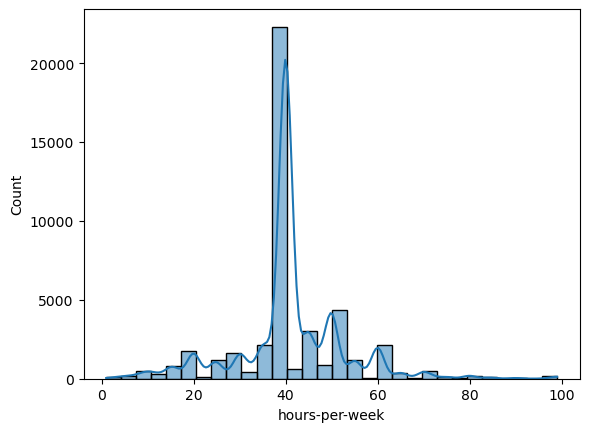

In [40]:
sns.histplot(df['hours-per-week'], bins=30, kde=True)

**binning**

* (0, 20] → Part-time
* (20, 40] → Full-time
* (40, 60] → Overtime

In [41]:
# Binning 

bins=[0, 20, 40, 60, 100]
labels=['Part-time', 'Full-time', 'Overtime', 'Extreme']

df['work_hours_group'] = pd.cut(df['hours-per-week'], bins=bins, labels=labels)

<Axes: xlabel='work_hours_group', ylabel='Count'>

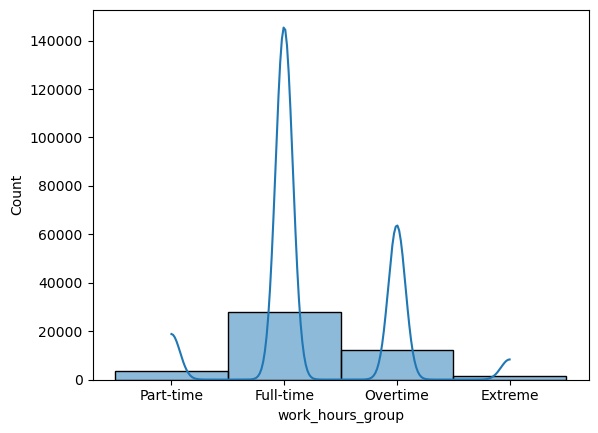

In [42]:
sns.histplot(df['work_hours_group'], bins=30, kde=True)

In [43]:
df['native-country'].value_counts() # highly imbalanced - remove

native-country
United-States                 41227
Mexico                          903
Philippines                     281
Germany                         193
Puerto-Rico                     175
Canada                          163
El-Salvador                     147
India                           147
Cuba                            133
England                         119
China                           113
Jamaica                         103
South                           101
Italy                           100
Dominican-Republic               97
Japan                            89
Guatemala                        86
Vietnam                          83
Columbia                         82
Poland                           81
Haiti                            69
Portugal                         62
Iran                             56
Taiwan                           55
Greece                           49
Nicaragua                        48
Peru                             45
Ecuador      

In [44]:
df = df.drop(['hours-per-week','native-country'], axis=1)

#### Encoding

##### *Encoding Categorical Features*

Encoding converts text labels into numerical representations that models can work with — in a way that preserves the meaning without implying false relationships.

| Feature          | Cardinality | Type    | Cardinality cat | Encoding method  |
| ---------------- | ----------- | ------- | --------------- | ---------------- |
| `age_group`      | 7           | Ordinal | Low cardinality | Ordinal encoder  |
| `workclass`      | 3           | Nominal | Low cardinality | one-hot encoding |
| `marital-status` | 4           | Nominal | Low cardinality | one-hot encoding |
| `occupation`     | 12          | Nominal | Mid cardinality | one-hot encoding |
| `work_hours_group`| 4          | Nominal | Low cardinality | one-hot encoding |
| `gender`         | 2           | Nominal | Low cardinality | Binary           |
| `income`         | 2           | Nominal | **Target** variable | Binary       |



In [45]:
df.dtypes

workclass             object
educational-num        int64
marital-status        object
occupation            object
gender                object
income                object
age_group           category
work_hours_group    category
dtype: object

In [46]:
df.select_dtypes(include=['object','category']).nunique()

workclass            3
marital-status       4
occupation          12
gender               2
income               2
age_group            7
work_hours_group     4
dtype: int64

In [47]:
df.head()

,workclass,educational-num,marital-status,occupation,gender,income,age_group,work_hours_group
0,Private,7,Never-married,Machine-op-inspct,Male,<=50K,20-30,Full-time
1,Private,9,Married-civ-spouse,Farming-fishing,Male,<=50K,30-40,Overtime
2,Gov-worker,12,Married-civ-spouse,Protective-serv,Male,>50K,20-30,Full-time
3,Private,10,Married-civ-spouse,Machine-op-inspct,Male,>50K,40-50,Full-time
5,Private,6,Never-married,Other-service,Male,<=50K,30-40,Full-time


In [48]:
df_encoded = df.copy()

In [49]:
# Ordinal encoder

# Define ordered labels 
labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']

# Make sure age_group is ordered categorical
df_encoded['age_group'] = pd.Categorical(df_encoded['age_group'], categories=labels, ordered=True)

encoder = OrdinalEncoder(categories=[labels])
df_encoded['age_group_encoded'] = encoder.fit_transform(df_encoded[['age_group']]).ravel()
df_encoded['age_group_encoded'] = df_encoded['age_group_encoded'].astype(int) # for consistency
df_encoded = df_encoded.drop(['age_group'], axis=1)

# Create mapping table
age_group_mapping = {i: label for i, label in enumerate(labels)}
age_group_mapping_df = pd.DataFrame(list(age_group_mapping.items()), columns=['Encoded Value', 'Age Group Label'])


df_encoded.head()

,workclass,educational-num,marital-status,occupation,gender,income,work_hours_group,age_group_encoded
0,Private,7,Never-married,Machine-op-inspct,Male,<=50K,Full-time,1
1,Private,9,Married-civ-spouse,Farming-fishing,Male,<=50K,Overtime,2
2,Gov-worker,12,Married-civ-spouse,Protective-serv,Male,>50K,Full-time,1
3,Private,10,Married-civ-spouse,Machine-op-inspct,Male,>50K,Full-time,3
5,Private,6,Never-married,Other-service,Male,<=50K,Full-time,2


In [50]:
age_group_mapping_df

,Encoded Value,Age Group Label
0,0,<20
1,1,20-30
2,2,30-40
3,3,40-50
4,4,50-60
5,5,60-70
6,6,70+


In [51]:
df_encoded["age_group_encoded"].value_counts()

age_group_encoded
2    12343
1    10971
3    10299
4     6259
5     2507
0     2046
6      730
Name: count, dtype: int64

In [52]:
df_encoded.dtypes

workclass              object
educational-num         int64
marital-status         object
occupation             object
gender                 object
income                 object
work_hours_group     category
age_group_encoded       int64
dtype: object

In [53]:
df_encoded.columns

Index(['workclass', 'educational-num', 'marital-status', 'occupation',
       'gender', 'income', 'work_hours_group', 'age_group_encoded'],
      dtype='object')

In [54]:
# Nominal encoder - One hot encoder - ASK IF THERES A BETTER WAY!
df_encoded = pd.get_dummies(
    df_encoded, 
    columns=['workclass', 'marital-status', 'occupation', 'gender', 'work_hours_group', 'income'], 
    drop_first=True,
    dtype=int
)

df_encoded.head()

,educational-num,age_group_encoded,workclass_Private,workclass_Self-employed,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,gender_Male,work_hours_group_Full-time,work_hours_group_Overtime,work_hours_group_Extreme,income_>50K
0,7,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,9,2,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
2,12,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
3,10,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
5,6,2,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [55]:
df_encoded.describe().round(2)

,educational-num,age_group_encoded,workclass_Private,workclass_Self-employed,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,gender_Male,work_hours_group_Full-time,work_hours_group_Overtime,work_hours_group_Extreme,income_>50K
count,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,...,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00,45155.00
mean,10.12,2.40,0.74,0.12,0.32,0.18,0.03,0.13,0.13,0.03,...,0.13,0.02,0.12,0.03,0.05,0.68,0.62,0.27,0.04,0.25
std,2.55,1.34,0.44,0.33,0.47,0.39,0.17,0.34,0.34,0.18,...,0.34,0.15,0.32,0.17,0.22,0.47,0.49,0.44,0.18,0.43
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,9.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,10.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
75%,13.00,3.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00
max,16.00,6.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [56]:
df.shape

(45155, 8)

In [57]:
df_encoded.shape

(45155, 23)

In [58]:
df_encoded.columns

Index(['educational-num', 'age_group_encoded', 'workclass_Private',
       'workclass_Self-employed', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'gender_Male',
       'work_hours_group_Full-time', 'work_hours_group_Overtime',
       'work_hours_group_Extreme', 'income_>50K'],
      dtype='object')

In [59]:
df = df_encoded.copy()

#### Train, Validate, Test Split

This splits your dataset into **training and testing sets**, while keeping the features and labels properly aligned. 

It splits the shuffled DataFrame into 3 parts:
* First 60% → train
* Next 20% → valid
* Final 20% → test

In [60]:
X = df.drop(columns='income_>50K')
y = df['income_>50K']

In [61]:
# Step 1: Split X and y into Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Step 2: Split Temp into Validation (20%) and Test (20%)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

#### Scaling

##### *Scaling Dataset*

The dataset has features with varying scales, particularly the `age` feature, which has a large range.

* Scaling ensures that all features contribute equally to the model. 

**Standarization** puts all features on the same scale. 

*It doesn't change the relationships between values. It normalizes them to a standard scale.* 

**ONLY FIT TO THE TRAINING SET** 

You scale all sets, but only fit the scaler on training data.

In [62]:
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Don't truncate based on screen width
pd.set_option('display.max_colwidth', None)  # Show full content in each cell

In [63]:
df.describe().loc[['min', 'max']].round(2)

,educational-num,age_group_encoded,workclass_Private,workclass_Self-employed,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,gender_Male,work_hours_group_Full-time,work_hours_group_Overtime,work_hours_group_Extreme,income_>50K
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,16.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [64]:
# I decided to bin the age feature and encode it ordinally. No scaling needed anymore
'''
scaler = StandardScaler()

# IMPORTANT: fit only on training data - here we will only scale the age feature.
scaler.fit(X_train[['age']])

# Apply the same transformation to all splits
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled  = X_test.copy()

X_train_scaled['age'] = scaler.transform(X_train[['age']])
X_valid_scaled['age'] = scaler.transform(X_valid[['age']])
X_test_scaled['age']  = scaler.transform(X_test[['age']])
'''
pass

#### Balancing

##### *Imbalanced Dataset*

The dataset shows a significant imbalance, with only about 25% of individuals earning more than 50K annually.

Our data is **labeled** (`income` feature) 
- In this notebook I will be implementing various **supervised** classification models.
- I will use `income` as my target vector.

The models I will be implementing are sensitive to imbalanced data. Why?
- **Most distance-based, probabilistic, and linear models are sensitive to imbalanced data** as these models favour the majority class.
- If the model is trained without fixing this issue, it'll return obsolete predictions with "high" accuracy.
- As per recommendations from other peers in the ML space, I will balance the dataset using weights instead of oversampling or undersampling. 

In [65]:
round(df['income_>50K'].value_counts(normalize=True) * 100, 2)

income_>50K
0    75.22
1    24.78
Name: proportion, dtype: float64

**The balancing will be taken care of within the model parameters as we are going with a weighted approach**

### 4.0 Model Training & Testing

#### XG Boost

In [76]:
from xgboost import XGBClassifier

In [77]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [78]:
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      6794
           1       0.55      0.82      0.66      2237

    accuracy                           0.79      9031
   macro avg       0.74      0.80      0.76      9031
weighted avg       0.84      0.79      0.80      9031



**Analysis**
* The model is good at identifying class 1 cases (recall is strong), but often misclassifies others as class 1 (low precision).
* This might be acceptable if your goal is to **maximize finding high-income individuals, even at the cost of false positives**.
 
**TLDR:** The XGB model recovers a lot of the >50K cases (recall = 0.82) but makes more mistakes when predicting them (precision = 0.55).

#### Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [75]:
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      6794
           1       0.56      0.76      0.65      2237

    accuracy                           0.80      9031
   macro avg       0.74      0.78      0.75      9031
weighted avg       0.83      0.80      0.80      9031



**Analysis**

* The model captures many of the >50K cases (recall = 0.76), though not as strongly as XGBoost.

* Precision is slightly better than XGBoost (0.56 vs. 0.55), meaning it makes fewer false positive errors when predicting high-income.

* Overall, the model strikes a better balance between catching >50K earners and not over-predicting them.

Compared to XGBoost, Random Forest is more conservative. 

**TLDR:** It misses slightly more high earners, but is more accurate when it does predict them.

#### Logistic Regression

Predicts the probability that a datapoint belongs to a class by fitting the data to a sigmoid curve. 
* Mostly used for binary classification


In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
lg_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lg_model = lg_model.fit(X_train, y_train)

In [72]:
y_pred_lg = lg_model.predict(X_test)
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      6794
           1       0.54      0.82      0.65      2237

    accuracy                           0.78      9031
   macro avg       0.74      0.80      0.75      9031
weighted avg       0.83      0.78      0.80      9031



**Analysis**
* Similar to XGBoost, the model recovers many of the >50K cases (recall = 0.82), which is useful if high recall is important.

* Precision is slightly lower (0.54), meaning it produces more false positives than Random Forest.

**TLDR:** This model catches most high-income cases, but has a higher false positive rate.

#### KNN - K Nearest Neighbors

KNN makes predictions based on the 'closeness' of training data.

* It doesn't *learn* the mode -> it stores training data and makes predictions at runtime.

i.e. To predict a label for a new point, look at the closest k points in the training data & choose the majority class.

In [66]:
from sklearn.neighbors import KNeighborsClassifier

In [67]:
# Model training
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train, y_train)

,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [68]:
# Predictions
y_pred_knn = knn_model.predict(X_test)

In [69]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      6794
           1       0.63      0.55      0.58      2237

    accuracy                           0.81      9031
   macro avg       0.74      0.72      0.73      9031
weighted avg       0.80      0.81      0.80      9031



**Analysis**

* KNN achieves strong performance for class 0 (<=50K) with high precision (0.86) and recall (0.89).

* However, it struggles with class 1 (>50K), recall drops to 0.55, and f1-score is the lowest (0.58).

*This shows KNN is biased toward the majority class, missing many high-income individuals.*

KNN is not ideal if the goal is to maximize detection of high-income individuals. 

**TLDR:** It performs well overall but underperforms in capturing the minority class, which is critical in imbalanced problems.

### 5.0 Conclusion

1. Use XGBoost if recall is the priority (high-income people are rare and important to catch)
2. Use Random Forest if you want overall reliable performance without too many false alarms